# Procesamiento de Lenguaje Natural

![Colegio Bourbaki](./Images/Bourbaki.png)

## Clasificador de reclamos del Consumidor

Los datos que se utilizan en este notebook proceden de la Base de Datos de Reclamos de los Consumidores que publica la Oficina de Protección Financiera del Consumidor (CFPB), una agencia gubernamental estadounidense. 

La Base de Datos de Reclamos de los Consumidores es una recopilación de reclamos sobre productos y servicios financieros de consumo que la CFPB envía a las empresas para que respondan. 

Una queja/denuncia/reclamo contiene la descripción narrativa del consumidor sobre su experiencia si el consumidor optó por compartir esta información públicamente y después de que la Oficina haya eliminado toda la información personal.

Los datos están a disposición del público en https://www.consumerfinance.gov/data-research/consumer-complaints/.

### Librerias

In [1]:
#Data Analysis
import numpy as np
import pandas as pd

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#Text Processing
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud

#Classifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

#Metrics
from sklearn.metrics import accuracy_score, classification_report, roc_curve,auc

#Utils
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

### Configuraciónes

In [2]:
pd.options.display.max_colwidth = 500

In [3]:
nlp = spacy.load(
    "en_core_web_sm", disable=["ner", "parser"]
)  # solo necesitamos tokenizer + tagger + lemmatizer

### Funciones de ayuda

In [4]:
def generate_wordcloud(texts):
    """ Genera una nube de palabras a partir de una lista de textos """
    # Crear la cadena con la que haremos la nube de palabras
    combined_text = " ".join(text for text in texts)
    
    # Crear la nube de palabras
    wordcloud = WordCloud(max_font_size=50, 
                          max_words=100, 
                          background_color="white", 
                          normalize_plurals=False, 
                          collocations=False).generate(combined_text)
    

    # Desplegar la imagen generada
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

In [5]:
def preprocessing(text: str) -> str:
    """
    Preprocesa texto en inglés usando spaCy:
    - Minúsculas
    - Tokeniza
    - Quita puntuación, números y stopwords
    - Lematiza con POS
    """
    if not isinstance(text, str):
        return ""

    doc = nlp(text.lower())
    words = [
        token.lemma_
        for token in doc
        if token.is_alpha and not token.is_stop and len(token) > 2
    ]
    return " ".join(words)

In [6]:
def confusion_matrix(y_real, y_pred):
    """ Muestra la matrix de confusión entre datos reales y predichos por un modelo"""
    data = {'Y_Real': y_real,
            'Y_Prediccion': y_pred
            }

    df = pd.DataFrame(data, columns=['Y_Real', 'Y_Prediccion'])
    confusion_matrix = pd.crosstab(df['Y_Real'], df['Y_Prediccion'], rownames=['Real'], colnames=['Predicted'])

    sns.heatmap(confusion_matrix, annot=True, fmt='g')
    plt.show()

In [7]:
def plot_ovr_roc(
    y_true,
    y_score,
    classes=None,
    title="One-vs-Rest ROC",
    add_micro=True,
    add_macro=True,
):
    """
    Plot OvR ROC curves for a multiclass classifier.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        True class labels.

    y_score : array-like of shape (n_samples, n_classes)
        Per-class scores (e.g., predict_proba or decision_function).
        Must have one column per class in `classes` order.

    classes : list/array of shape (n_classes,), optional
        Class labels in the exact order that matches y_score's columns.
        If None, inferred from y_true (and must match y_score columns).

    add_micro : bool
        Plot micro-average ROC.

    add_macro : bool
        Plot macro-average ROC.
    """
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)

    if classes is None:
        classes = np.unique(y_true)
    classes = np.asarray(classes)

    if y_score.ndim != 2 or y_score.shape[1] != len(classes):
        raise ValueError(
            "y_score must be (n_samples, n_classes) and match len(classes)."
        )

    # Binarize y
    y_true_bin = label_binarize(y_true, classes=classes)

    fpr, tpr, roc_auc = {}, {}, {}

    # Per-class ROC
    for i, cls in enumerate(classes):
        y_i = y_true_bin[:, i]
        # Need both positive and negative samples to compute ROC
        if y_i.sum() == 0 or y_i.sum() == y_i.shape[0]:
            # skip classes with only one label present
            continue
        fpr[cls], tpr[cls], _ = roc_curve(y_i, y_score[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    # Micro-average
    if add_micro and len(roc_auc) > 0:
        fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Macro-average
    if add_macro and len(roc_auc) > 0:
        # Aggregate all fpr points
        class_keys = [k for k in roc_auc.keys() if k not in ("micro", "macro")]
        all_fpr = np.unique(np.concatenate([fpr[k] for k in class_keys]))
        mean_tpr = np.zeros_like(all_fpr)
        for k in class_keys:
            mean_tpr += np.interp(all_fpr, fpr[k], tpr[k])
        mean_tpr /= len(class_keys)
        fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot
    plt.figure(figsize=(8, 6))
    color_cycle = cycle([f"C{i}" for i in range(10)])

    # Per-class curves
    for cls, color in zip(
        [k for k in roc_auc.keys() if k not in ("micro", "macro")], color_cycle
    ):
        plt.plot(fpr[cls], tpr[cls], lw=2, label=f"{cls} (AUC={roc_auc[cls]:.2f})")

    # Micro / Macro
    if "micro" in roc_auc:
        plt.plot(
            fpr["micro"],
            tpr["micro"],
            linestyle=":",
            lw=2,
            label=f"micro (AUC={roc_auc['micro']:.2f})",
        )
    if "macro" in roc_auc:
        plt.plot(
            fpr["macro"],
            tpr["macro"],
            linestyle="--",
            lw=2,
            label=f"macro (AUC={roc_auc['macro']:.2f})",
        )

    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.xlim(0, 1)
    plt.ylim(0, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right", fontsize="small")
    plt.tight_layout()
    plt.show()

### Importación de Datos

Los datos pueden descargarse a través de una API desde https://www.consumerfinance.gov/data-research/consumer-complaints/ o descargarse en formato csv en https://files.consumerfinance.gov/ccdb/complaints.csv.zip

Encontraremos una explicación detallada de las columnas disponibles aquí: https://www.consumerfinance.gov/complaint/data-use/#:~:text=Types%20of%20complaint%20data%20we%20publish .

Nuestro análisis se centrará en la columna Producto, que contiene el grupo de productos, y en la columna con el texto del reclamo Relato de la reclamo del consumidor. Como el dataset es muy grande (>3GB) solo importaremos estas dos columnas.

In [8]:
df = pd.read_csv(
    "./Data/complaints.csv",
    usecols=["Consumer complaint narrative", "Product"],
    # engine="python",  # more tolerant of bad quoting
    # low_memory=False
)

### Análisis Exploratorio

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5038190 entries, 0 to 5038189
Data columns (total 2 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Product                       object
 1   Consumer complaint narrative  object
dtypes: object(2)
memory usage: 76.9+ MB


In [10]:
df.head()

,Product,Consumer complaint narrative
0,Credit reporting or other personal consumer reports,On XX/XX/2023 I mailed a certified letter to Experian XXXXXXXX XXXX XXXX XXXX XXXX XXXXXXXX asking to remove this inaccurate Bankruptcy information that's reporting on my consumer credit report. They have yet to respond or delete this from my credit report! No consumer reporting agency may furnish a consumer report to any person if it has reasonable grounds for believing that the consumer report will not be used for a purpose listed in section 1681b of this title. Consumer Reports Fair Credi...
1,Credit reporting or other personal consumer reports,NaN
2,Credit reporting or other personal consumer reports,NaN
3,Credit reporting or other personal consumer reports,NaN
4,Credit reporting or other personal consumer reports,NaN


In [11]:
df.tail()

,Product,Consumer complaint narrative
5038185,"Credit reporting, credit repair services, or other personal consumer reports",NaN
5038186,"Payday loan, title loan, or personal loan",NaN
5038187,Mortgage,NaN
5038188,"Credit reporting, credit repair services, or other personal consumer reports",NaN
5038189,"Payday loan, title loan, or personal loan",NaN


In [12]:
df.isna().sum()

Product                               0
Consumer complaint narrative    3261082
dtype: int64

In [13]:
df.dropna(subset=['Consumer complaint narrative'], inplace=True)

In [14]:
df.isna().sum()

Product                         0
Consumer complaint narrative    0
dtype: int64

In [15]:
dup_mask = df.duplicated(subset="Consumer complaint narrative", keep=False)
print("Duplicate rows:", dup_mask.sum())

Duplicate rows: 421838


In [16]:
df = df.drop_duplicates(subset=['Consumer complaint narrative'], keep='first', inplace=False)

In [17]:
df['Product']

0          Credit reporting or other personal consumer reports
7          Credit reporting or other personal consumer reports
8          Credit reporting or other personal consumer reports
33         Credit reporting or other personal consumer reports
38         Credit reporting or other personal consumer reports
                                  ...                         
5038027                            Credit card or prepaid card
5038072                                               Mortgage
5038106     Money transfer, virtual currency, or money service
5038111                                        Debt collection
5038160                                               Mortgage
Name: Product, Length: 1455093, dtype: object

In [18]:
df['Product'].value_counts()

Product
Credit reporting, credit repair services, or other personal consumer reports    584933
Debt collection                                                                 228474
Mortgage                                                                        115225
Credit reporting or other personal consumer reports                             107845
Credit card or prepaid card                                                     103882
Checking or savings account                                                      91398
Student loan                                                                     41379
Money transfer, virtual currency, or money service                               38156
Credit card                                                                      33656
Credit reporting                                                                 29789
Vehicle loan or lease                                                            29288
Payday loan, title loan, or persona

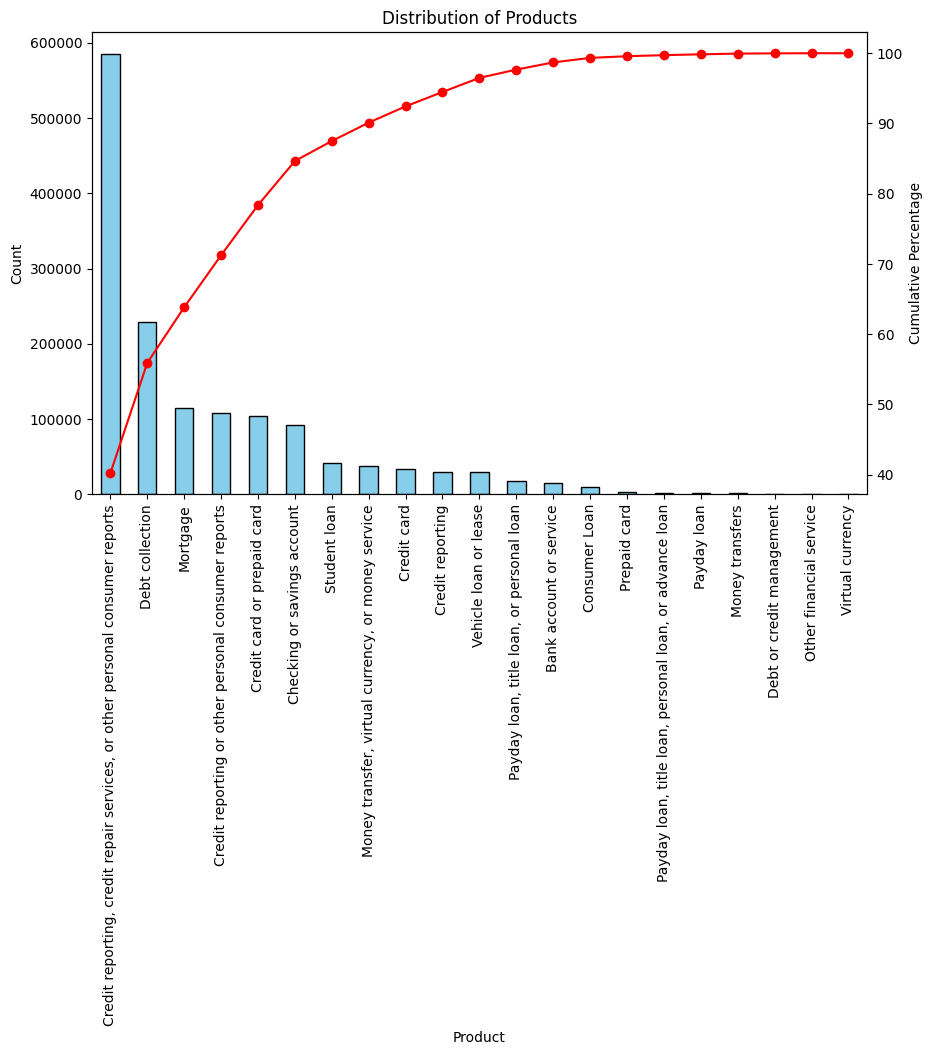

In [19]:
# Plot the bar chart
fig, ax1 = plt.subplots(figsize=(10, 6))
df['Product'].value_counts().plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black')
plt.title('Distribution of Products')
plt.xlabel('Product')
plt.ylabel('Count')

# Create a second y-axis for CDF
ax2 = ax1.twinx()
cumulative_counts = df['Product'].value_counts().cumsum()
cumulative_percentages = cumulative_counts / cumulative_counts.max() * 100
cumulative_percentages.plot(kind='line', color='red', ax=ax2, marker='o')
ax2.set_ylabel('Cumulative Percentage')
ax2.tick_params(axis='y')

plt.show()

Vamos a remapear las clases.

In [20]:
# mapping dictionary
label_map = {
    "Credit reporting, credit repair services, or other personal consumer reports": "Credit Reporting & Repair",
    "Credit reporting or other personal consumer reports": "Credit Reporting & Repair",
    "Credit reporting": "Credit Reporting & Repair",
    "Debt collection": "Debt Collection",
    "Mortgage": "Mortgage",
    "Credit card or prepaid card": "Credit & Prepaid Cards",
    "Credit card": "Credit & Prepaid Cards",
    "Prepaid card": "Credit & Prepaid Cards",
    "Checking or savings account": "Bank Accounts & Services",
    "Bank account or service": "Bank Accounts & Services",
    "Student loan": "Student Loans",
    "Vehicle loan or lease": "Consumer Loans (Non-Mortgage)",
    "Payday loan, title loan, or personal loan": "Consumer Loans (Non-Mortgage)",
    "Payday loan, title loan, personal loan, or advance loan": "Consumer Loans (Non-Mortgage)",
    "Payday loan": "Consumer Loans (Non-Mortgage)",
    "Consumer Loan": "Consumer Loans (Non-Mortgage)",
    "Money transfer, virtual currency, or money service": "Money Transfers & Virtual Currency",
    "Money transfers": "Money Transfers & Virtual Currency",
    "Virtual currency": "Money Transfers & Virtual Currency",
    "Debt or credit management": "Debt & Credit Management",
    "Other financial service": "Other Financial Services",
}

# apply mapping
df["Product"] = df["Product"].map(label_map)

In [21]:
df['Product'].value_counts()

Product
Credit Reporting & Repair             722567
Debt Collection                       228474
Credit & Prepaid Cards                140986
Mortgage                              115225
Bank Accounts & Services              106251
Consumer Loans (Non-Mortgage)          59778
Student Loans                          41379
Money Transfers & Virtual Currency     39666
Debt & Credit Management                 476
Other Financial Services                 291
Name: count, dtype: int64

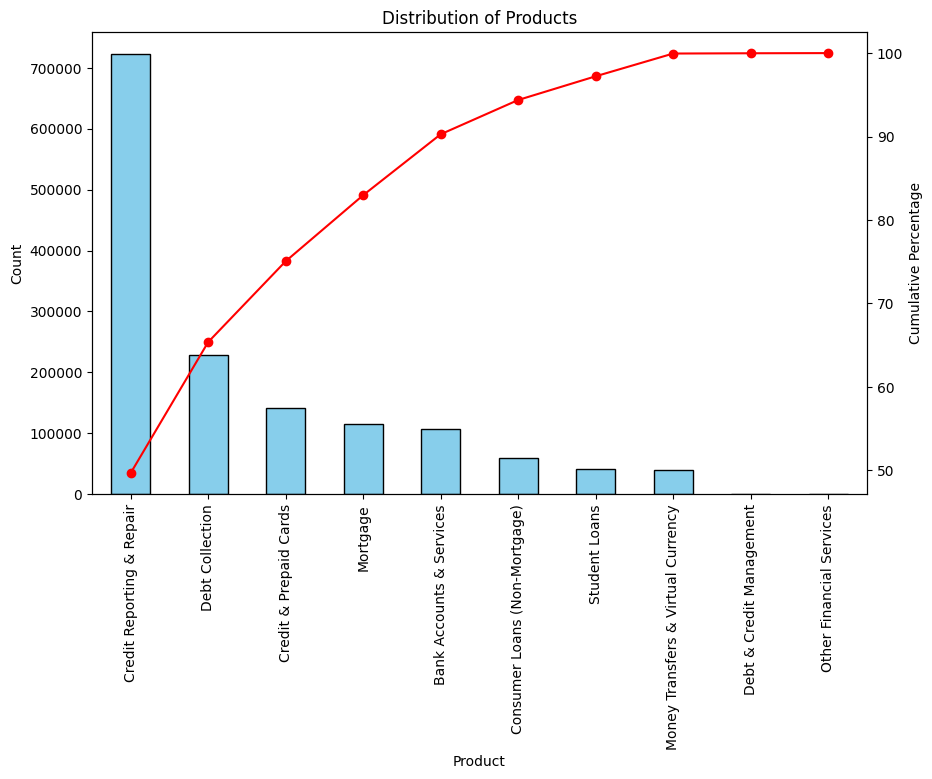

In [22]:
# Plot the bar chart
fig, ax1 = plt.subplots(figsize=(10, 6))
df["Product"].value_counts().plot(
    kind="bar", figsize=(10, 6), color="skyblue", edgecolor="black"
)
plt.title("Distribution of Products")
plt.xlabel("Product")
plt.ylabel("Count")

# Create a second y-axis for CDF
ax2 = ax1.twinx()
cumulative_counts = df["Product"].value_counts().cumsum()
cumulative_percentages = cumulative_counts / cumulative_counts.max() * 100
cumulative_percentages.plot(kind="line", color="red", ax=ax2, marker="o")
ax2.set_ylabel("Cumulative Percentage")
ax2.tick_params(axis="y")

plt.show()

Como vemos las clases estan muy desbalanceadas.

Por lo tanto, por cuestiones de balanceo y también, de memoria en el preprocessing de los textos, trabajaremos con las 6 primeras etiquetas haciendo un undersampling entre 3500 y 4000 registros.


In [23]:
selected_classes = [
    "Credit Reporting & Repair",
    "Debt Collection",	
    "Credit & Prepaid Cards",
    "Mortgage",
    "Bank Accounts & Services",
    "Consumer Loans (Non-Mortgage)",
    "Student Loans",
    "Money Transfers & Virtual Currency"
]

In [24]:
filtered_df = df[df["Product"].isin(selected_classes)]

In [25]:
filtered_df['Product'].value_counts()

Product
Credit Reporting & Repair             722567
Debt Collection                       228474
Credit & Prepaid Cards                140986
Mortgage                              115225
Bank Accounts & Services              106251
Consumer Loans (Non-Mortgage)          59778
Student Loans                          41379
Money Transfers & Virtual Currency     39666
Name: count, dtype: int64

In [26]:
# Set target count range for undersampling
target_count_range = (3500, 4000)

# Undersample the selected classes
undersampled_data = []

for product_class in selected_classes:
    target = np.random.randint(target_count_range[0], target_count_range[1])
    class_subset = filtered_df[filtered_df["Product"] == product_class].sample(
        n=target, random_state=42
    )
    undersampled_data.append(class_subset)

# Concatenate the undersampled data
undersampled_df = pd.concat(undersampled_data)

# Shuffle the resulting DataFrame
undersampled_df = undersampled_df.sample(frac=1, random_state=42)

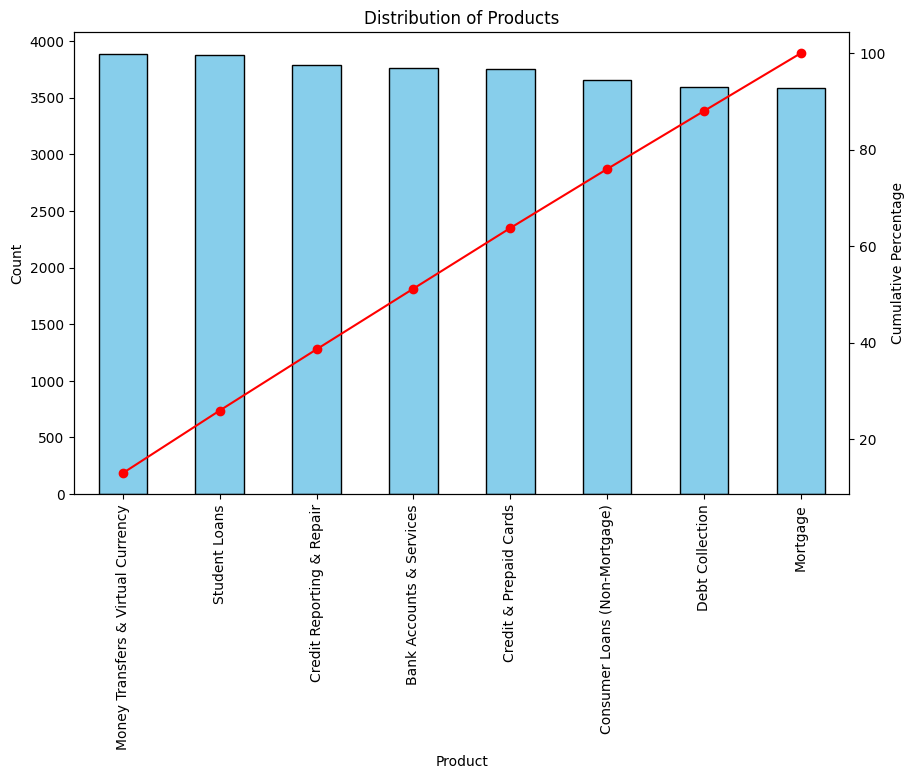

In [27]:
# Plot the bar chart
fig, ax1 = plt.subplots(figsize=(10, 6))
undersampled_df["Product"].value_counts().plot(
    kind="bar", figsize=(10, 6), color="skyblue", edgecolor="black"
)
plt.title("Distribution of Products")
plt.xlabel("Product")
plt.ylabel("Count")


# Create a second y-axis for CDF
ax2 = ax1.twinx()
cumulative_counts = undersampled_df["Product"].value_counts().cumsum()
cumulative_percentages = cumulative_counts / cumulative_counts.max() * 100
cumulative_percentages.plot(kind="line", color="red", ax=ax2, marker="o")

ax2.set_ylabel("Cumulative Percentage")
ax2.tick_params(axis="y")

In [28]:
undersampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29890 entries, 3201493 to 4164659
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Product                       29890 non-null  object
 1   Consumer complaint narrative  29890 non-null  object
dtypes: object(2)
memory usage: 700.5+ KB


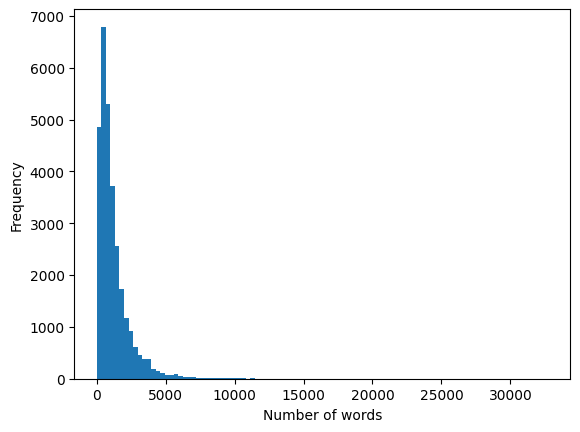

In [29]:
undersampled_df["Consumer complaint narrative"].str.len().plot.hist(bins=100)
plt.xlabel("Number of words")
plt.show()

In [30]:
undersampled_df["Consumer complaint narrative"].str.len().describe()

count    29890.00000
mean      1243.03001
std       1405.57308
min         15.00000
25%        466.00000
50%        862.00000
75%       1536.00000
max      32722.00000
Name: Consumer complaint narrative, dtype: float64

In [31]:
# Filter len < 10000
undersampled_df = undersampled_df[undersampled_df["Consumer complaint narrative"].str.len() < 10000]

In [32]:
X = undersampled_df["Consumer complaint narrative"].astype(
    str
)  # Convertimos la columna a tipo 'string', ya que es 'object'

In [34]:
X = X.transform(preprocessing, axis=0)  # Aplicamos la función de preprocesamiento

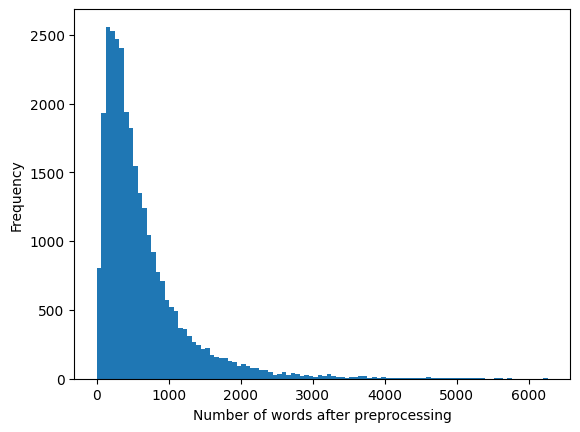

In [35]:
X.str.len().plot.hist(bins=100)
plt.xlabel('Number of words after preprocessing')
plt.show()

In [36]:
X.str.len().describe()

count    29805.000000
mean       634.695722
std        624.740786
min          0.000000
25%        242.000000
50%        447.000000
75%        799.000000
max       6268.000000
Name: Consumer complaint narrative, dtype: float64

In [37]:
all_text = ' '.join(X)
words = all_text.split()
unique_words_count = len(set(word.lower() for word in words))

print(f"Número único de palabras: {unique_words_count}")

Número único de palabras: 24617


Estos análisis nos ofrecen una idea o intuición de cuantás palabras deberiamos usar en nuestro vocabulario.

In [38]:
Y = undersampled_df['Product']

In [39]:
Y.value_counts()

Product
Money Transfers & Virtual Currency    3871
Student Loans                         3868
Credit Reporting & Repair             3776
Bank Accounts & Services              3752
Credit & Prepaid Cards                3747
Consumer Loans (Non-Mortgage)         3643
Debt Collection                       3583
Mortgage                              3565
Name: count, dtype: int64

Vamos a mapear las clases tipo 'string' a 'int':

In [40]:
aux = {item: index for index, item in enumerate(selected_classes)}
aux

{'Credit Reporting & Repair': 0,
 'Debt Collection': 1,
 'Credit & Prepaid Cards': 2,
 'Mortgage': 3,
 'Bank Accounts & Services': 4,
 'Consumer Loans (Non-Mortgage)': 5,
 'Student Loans': 6,
 'Money Transfers & Virtual Currency': 7}

In [41]:
Y = Y.map(aux)

In [42]:
Y.value_counts()

Product
7    3871
6    3868
0    3776
4    3752
2    3747
5    3643
1    3583
3    3565
Name: count, dtype: int64

Hagamos una visualización usando el concept nube de palabras

In [43]:
ensemble_data = pd.concat([X,Y], axis = 1)

Class:6


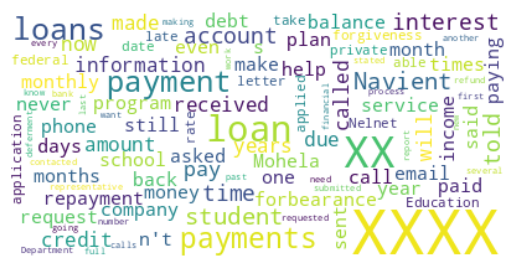

Class:1


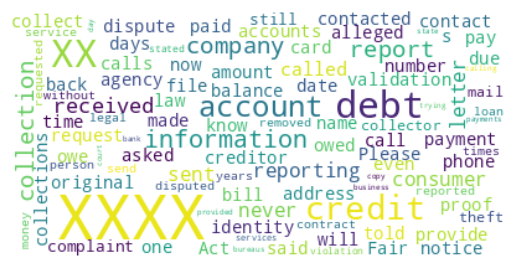

Class:2


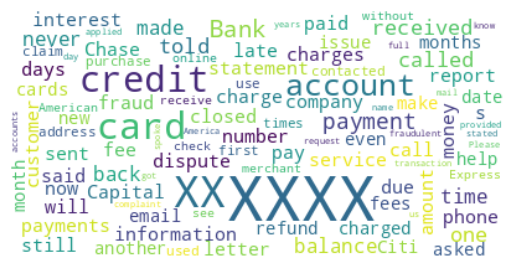

Class:0


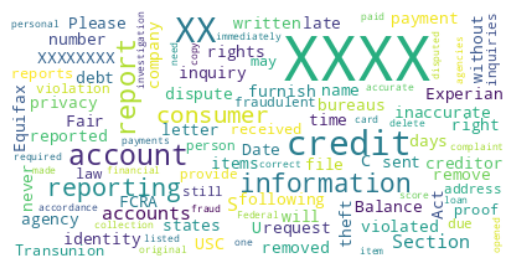

Class:4


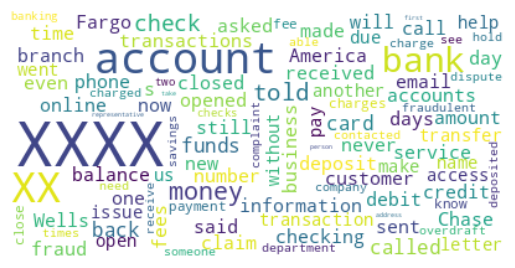

Class:3


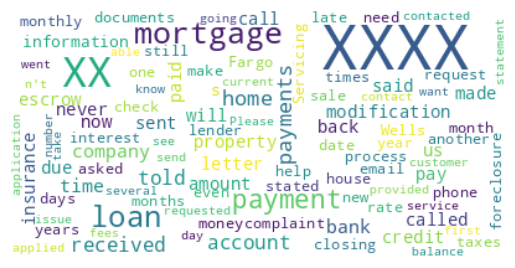

Class:7


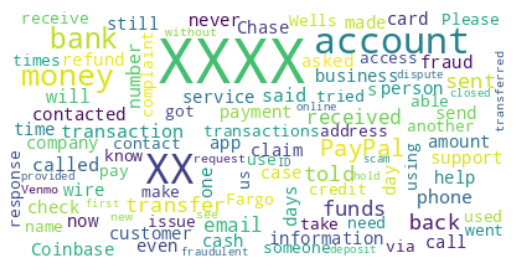

Class:5


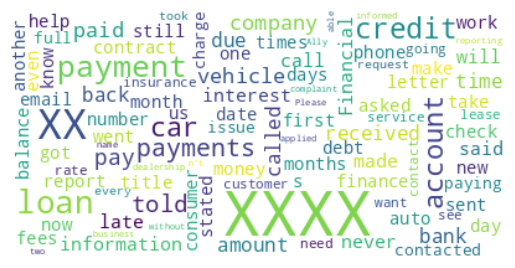

In [44]:
# Iterate over unique values in the 'Product' column
for item in ensemble_data['Product'].unique():
     print(f'Class:{item}')
     # Filter undersampled_df based on the current 'Product' value
     grouping = undersampled_df[ensemble_data['Product'] == item]['Consumer complaint narrative']
     # Generate word cloud for the filtered data
     generate_wordcloud(grouping)

Los string 'XXXX' y 'XX' aparecen contundemente en todas las clases, esto puede sesgar cualquier clasificador, por lo tanto vamos a removerlos.

In [45]:
# Remove 'xxxx' and 'xx' from every record
X = X.str.replace('xxxx', '').str.replace('xx', '')

In [46]:
ensemble_data_cleaned = pd.concat([X,Y], axis = 1)

Class:6


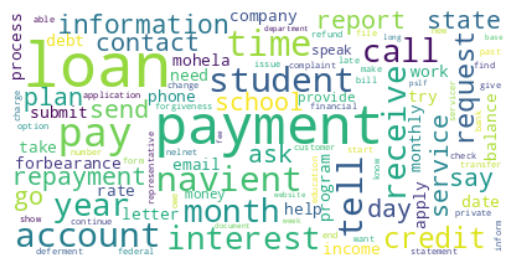

Class:1


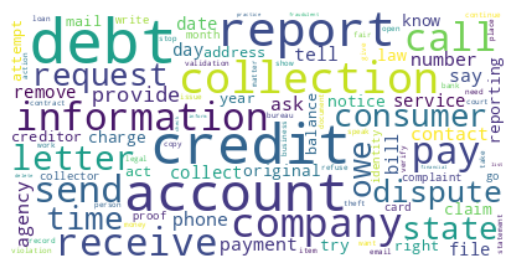

Class:2


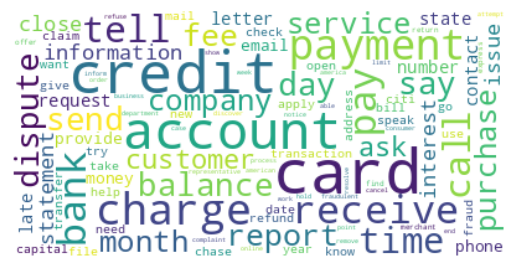

Class:0


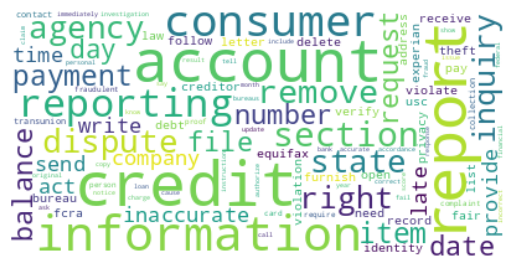

Class:4


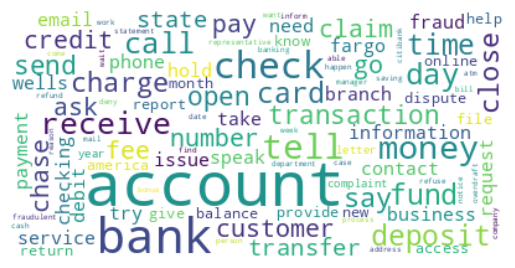

Class:3


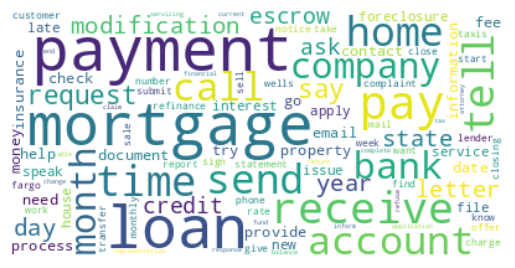

Class:7


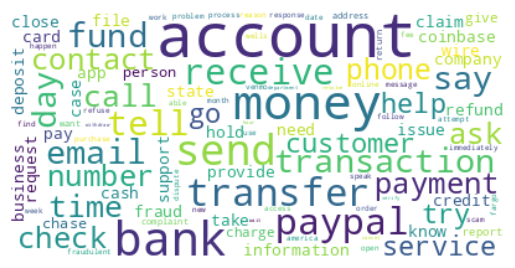

Class:5


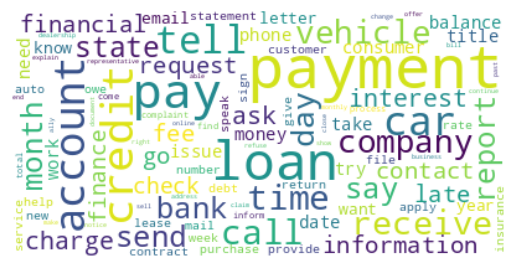

In [47]:
for item in ensemble_data_cleaned['Product'].unique():
    print(f'Class:{item}')
    grouping = ensemble_data_cleaned[ensemble_data_cleaned['Product'] == item]['Consumer complaint narrative']
    generate_wordcloud(grouping)

Separamos en conjunto de entrenamiento y prueba:

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

### Encajes de palabras (Word Embeddings)

¿Existen técnicas para vectorizar eficientemente oraciones desde el principio, cumpliendo con ciertos criterios? 

Consideraciones clave incluyen: 

* Evitar la generación de matrices dispersas debido a sus altos costos computacionales asociados
* Asegurar la retención de información lingüística sustancial dentro de la oración.

Una técnica efectiva para lograr esto es el **Word Embedding**, un método que representa el texto mediante vectores. Entre las formas populares de embeddings de palabras se encuentran la Bolsa de Palabras (BoW) y la Frecuencia de Términos-Inversa de Frecuencia en el Documento (TF-IDF).

Veamos cómo podemos aplicar estos métodos a nuestro dataset:

#### Bolsa de palabras (BoW)

Es el módelo mas simples para representar el texto mediante números. Podemos representar una oración como una bolsa de palabras vectorizada (una cadena de números).

Algunas desventajas:

* Si la oración contiene nuevas palabras, entonces el tamaño de nuestro vocabulario se incrementaría, y por lo tanto, el tamaño de nuestros vectores.

* Si los vectores contienen muchos 0's, la matriz resultante de palabras sería dispesa (es algo que queremos evitar por su alto costo computacional).

* No retenemos información acerca de la grámatica y semántica de las palabras o aún en el orden de las palabras en el texto.

In [49]:
# Bag of Words (BoW) representation
bow_vectorizer = CountVectorizer(max_features=784) #https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

In [50]:
X_train_bow.shape

(23844, 784)

In [51]:
words = bow_vectorizer.get_feature_names_out()
pd.DataFrame(X_train_bow.todense(), columns=words)

,ability,able,absolutely,accept,access,accord,accordance,account,accrue,acct,...,withdraw,withdrawal,work,worth,write,writing,wrong,year,yes,zelle
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23839,0,0,0,0,0,0,0,2,0,0,...,0,0,1,0,0,0,0,0,0,0
23840,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23841,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,1,2,0
23842,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,2,0,0,0,0,0


In [52]:
# Train SVM with BoW
svm_classifier_bow = LinearSVC(penalty='l2', C=0.0001, verbose=1)
svm_classifier_bow.fit(X_train_bow, y_train)
y_pred_bow = svm_classifier_bow.predict(X_test_bow)

[LibLinear]iter  1 act 1.481e+00 pre 1.387e+00 delta 3.930e-01 f 2.384e+00 |g| 1.818e+01 CG   4
iter  2 act 1.273e-01 pre 1.089e-01 delta 3.930e-01 f 9.030e-01 |g| 3.109e+00 CG   4
iter  3 act 3.063e-02 pre 2.553e-02 delta 3.930e-01 f 7.756e-01 |g| 1.029e+00 CG   4
iter  4 act 4.717e-03 pre 4.366e-03 delta 3.930e-01 f 7.450e-01 |g| 3.326e-01 CG   4
iter  5 act 1.712e-04 pre 1.694e-04 delta 3.930e-01 f 7.403e-01 |g| 4.973e-02 CG   5
iter  6 act 1.787e-06 pre 1.786e-06 delta 3.930e-01 f 7.401e-01 |g| 4.213e-03 CG   6
iter  1 act 1.419e+00 pre 1.306e+00 delta 3.499e-01 f 2.384e+00 |g| 1.861e+01 CG   3
iter  2 act 1.596e-01 pre 1.445e-01 delta 3.499e-01 f 9.657e-01 |g| 3.577e+00 CG   4
iter  3 act 1.823e-02 pre 1.610e-02 delta 3.499e-01 f 8.061e-01 |g| 8.678e-01 CG   5
iter  4 act 1.333e-03 pre 1.277e-03 delta 3.499e-01 f 7.878e-01 |g| 2.098e-01 CG   4
iter  5 act 4.671e-05 pre 4.665e-05 delta 3.499e-01 f 7.865e-01 |g| 2.308e-02 CG   5
iter  6 act 4.865e-07 pre 4.864e-07 delta 3.499e-01 f 

In [53]:
# Evaluate SVM with BoW
print("Classification Report using SVM with BoW:\n", classification_report(y_test, y_pred_bow))
print("Train Accuracy using SVM with BoW:", accuracy_score(y_train, svm_classifier_bow.predict(X_train_bow)))
print("Test Accuracy using SVM with BoW:", accuracy_score(y_test, y_pred_bow))

Classification Report using SVM with BoW:
               precision    recall  f1-score   support

           0       0.70      0.80      0.75       755
           1       0.73      0.73      0.73       717
           2       0.75      0.75      0.75       749
           3       0.91      0.87      0.89       713
           4       0.70      0.73      0.72       750
           5       0.80      0.60      0.69       729
           6       0.84      0.88      0.86       774
           7       0.77      0.80      0.78       774

    accuracy                           0.77      5961
   macro avg       0.77      0.77      0.77      5961
weighted avg       0.77      0.77      0.77      5961

Train Accuracy using SVM with BoW: 0.7797349438013756
Test Accuracy using SVM with BoW: 0.770340546888106


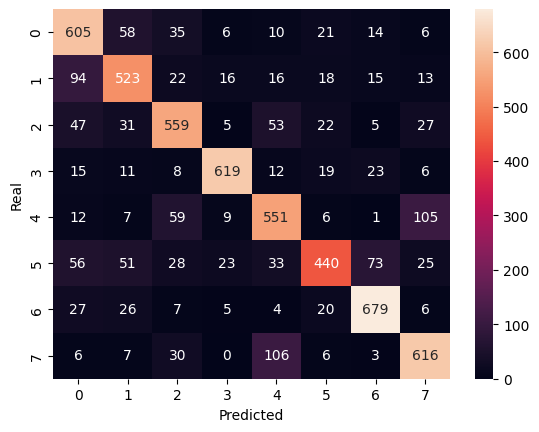

In [54]:
confusion_matrix(y_test, y_pred_bow)

In [55]:
y_score_bow = svm_classifier_bow.decision_function(
    X_test_bow
)  # shape: (n_samples, n_classes)

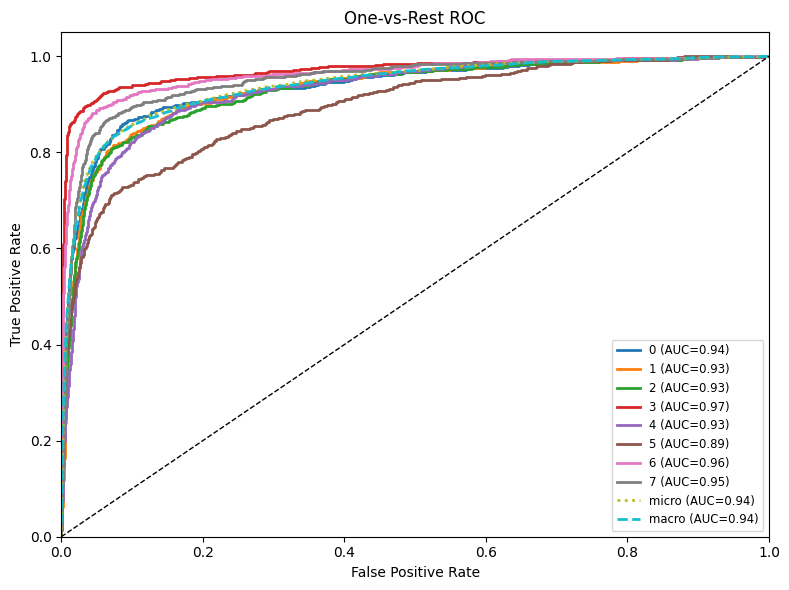

In [56]:
plot_ovr_roc(y_test, y_score_bow, svm_classifier_bow.classes_)

#### Frecuencia del Término - Frecuencia Inversa de los Documentos (TF-IDF)

Es un método estadístico que intenta reflejar cuán imporante es una palabra en un documento dentro de un corpus o colección de textos.

**Frequencia del Término:** Es una medida de cuán importante es un término a partir de cuantas veces aparece porcentualmente en un documento.

**Frecuencia Inversa de los Documentos:** es una medida de cuán importante es un término en general. Necesitamos este cálculo porque solo calcular la frecuencia del término no es suficiente para entender la importancia de las palabras.

Comparando con BoW, este primero crea un conjunto de vectores fáciles de interpretar conteniendo la cuenta de ocurrencias de una palabras en un documento, mientras que el segundo contiene información sobre las palabras más importantes y también de las menos importante. Por lo tanto, TF-IDF suele tener mejor performance en los modelos de ML.


In [57]:
# TF-IDF model
tfidf_vectorizer = TfidfVectorizer(max_features=784) #https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [58]:
X_train_tfidf.shape

(23844, 784)

In [59]:
words = tfidf_vectorizer.get_feature_names_out()
pd.DataFrame(X_train_tfidf.todense(), columns=words)

,ability,able,absolutely,accept,access,accord,accordance,account,accrue,acct,...,withdraw,withdrawal,work,worth,write,writing,wrong,year,yes,zelle
0,0.0,0.062464,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.051528,0.000000,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.122468,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.046955,0.075174,0.000000,0.000000,0.000000,0.0
3,0.0,0.075924,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.062631,0.000000,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23839,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.075112,0.0,0.0,...,0.0,0.0,0.069205,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
23840,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
23841,0.0,0.037397,0.0,0.0,0.0,0.0,0.0,0.019191,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.047497,0.030850,0.123201,0.0
23842,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.125925,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.166004,0.000000,0.000000,0.000000,0.000000,0.0


In [60]:
svm_classifier_tfidf = LinearSVC(penalty='l2', C=0.01, verbose=1)
svm_classifier_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = svm_classifier_tfidf.predict(X_test_tfidf)

[LibLinear]iter  1 act 1.348e+02 pre 1.348e+02 delta 7.282e-01 f 2.384e+02 |g| 3.702e+02 CG   1
cg reaches trust region boundary
iter  2 act 1.844e+01 pre 1.844e+01 delta 2.067e+00 f 1.036e+02 |g| 3.073e+01 CG   1
cg reaches trust region boundary
iter  3 act 2.534e+01 pre 2.438e+01 delta 2.181e+00 f 8.521e+01 |g| 3.666e+01 CG   2
iter  4 act 5.432e+00 pre 5.314e+00 delta 2.181e+00 f 5.986e+01 |g| 1.398e+01 CG   3
iter  5 act 2.126e-01 pre 2.087e-01 delta 2.181e+00 f 5.443e+01 |g| 3.141e+00 CG   3
iter  6 act 1.409e-02 pre 1.405e-02 delta 2.181e+00 f 5.422e+01 |g| 4.373e-01 CG   4
iter  7 act 1.420e-04 pre 1.420e-04 delta 2.181e+00 f 5.420e+01 |g| 3.366e-02 CG   5
iter  1 act 1.386e+02 pre 1.386e+02 delta 7.374e-01 f 2.384e+02 |g| 3.760e+02 CG   1
cg reaches trust region boundary
iter  2 act 1.482e+01 pre 1.482e+01 delta 2.347e+00 f 9.981e+01 |g| 2.384e+01 CG   1
cg reaches trust region boundary
iter  3 act 2.309e+01 pre 2.240e+01 delta 2.520e+00 f 8.499e+01 |g| 2.899e+01 CG   2
iter  4

In [61]:
print("Classification Report using TF-IDF:\n", classification_report(y_test, y_pred_tfidf))
print("Train Accuracy using SVM with TF-IDF:", accuracy_score(y_train, svm_classifier_tfidf.predict(X_train_tfidf)))
print("Accuracy using SVM with TF-IDF:", accuracy_score(y_test, y_pred_tfidf))

Classification Report using TF-IDF:
               precision    recall  f1-score   support

           0       0.73      0.80      0.76       755
           1       0.74      0.75      0.75       717
           2       0.75      0.76      0.76       749
           3       0.90      0.90      0.90       713
           4       0.71      0.76      0.74       750
           5       0.81      0.62      0.70       729
           6       0.86      0.88      0.87       774
           7       0.79      0.80      0.79       774

    accuracy                           0.78      5961
   macro avg       0.79      0.78      0.78      5961
weighted avg       0.79      0.78      0.78      5961

Train Accuracy using SVM with TF-IDF: 0.7952105351451099
Accuracy using SVM with TF-IDF: 0.7840966280825364


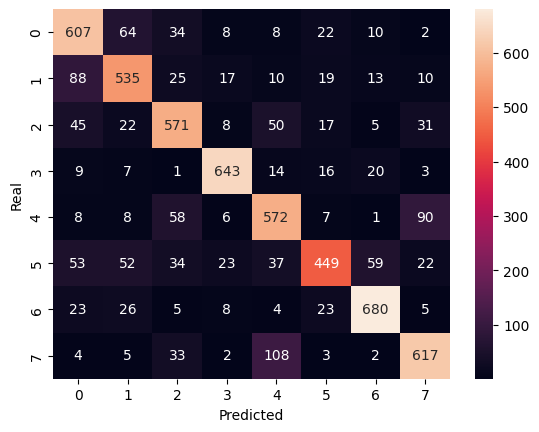

In [62]:
confusion_matrix(y_test, y_pred_tfidf)

In [63]:
y_score_tfidf = svm_classifier_tfidf.decision_function(X_test_tfidf)

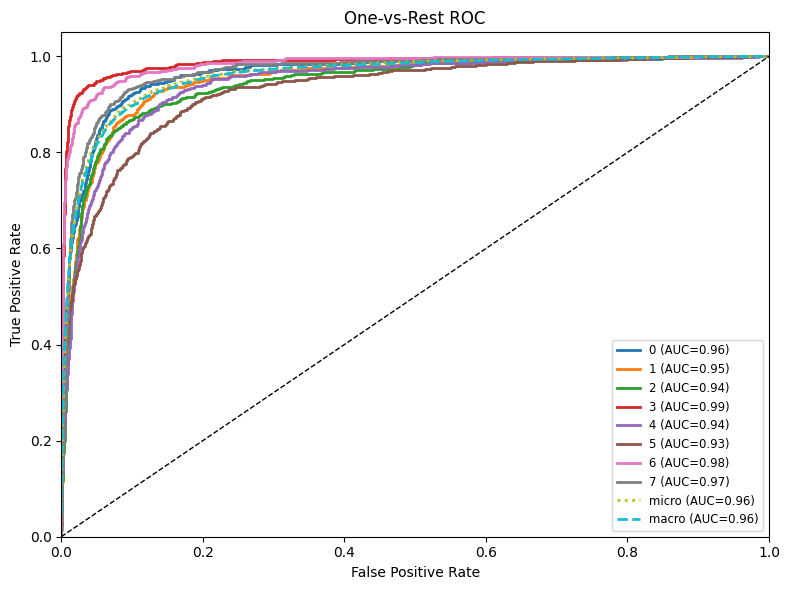

In [64]:
plot_ovr_roc(y_test, y_score_tfidf, svm_classifier_tfidf.classes_)

Observemos que la clasificación es mejor con el acercamiento TF-IDF que BOW.

### MLP Classifier

In [ ]:
# MLP Classifier with TF-IDF
mlp_classifier_tfidf = MLPClassifier(
    hidden_layer_sizes=(512,256,128),
    max_iter=30,
    verbose=1,
    learning_rate_init=0.0001,
    activation='relu',
    solver='adam',
    early_stopping=True,
    batch_size=256,
    alpha=0.0001,
)
mlp_classifier_tfidf.fit(X_train_tfidf, y_train)
y_pred_mlp = mlp_classifier_tfidf.predict(X_test_tfidf)

Iteration 1, loss = 2.01352824
Validation score: 0.637317
Iteration 2, loss = 1.54322474
Validation score: 0.714885
Iteration 3, loss = 0.94745905
Validation score: 0.774004
Iteration 4, loss = 0.71886645
Validation score: 0.793291
Iteration 5, loss = 0.64447574
Validation score: 0.802096


/home/pdconte/.local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:787: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [71]:
print(
    "Classification Report using MLP with TF-IDF:\n", classification_report(y_test, y_pred_tfidf)
)
print(
    "Train Accuracy using MLP with TF-IDF:",
    accuracy_score(y_train, svm_classifier_tfidf.predict(X_train_tfidf)),
)
print("Accuracy using MLP with TF-IDF:", accuracy_score(y_test, y_pred_tfidf))

Classification Report using MLP with TF-IDF:
               precision    recall  f1-score   support

           0       0.72      0.81      0.76       729
           1       0.76      0.74      0.75       703
           2       0.75      0.76      0.76       791
           3       0.87      0.89      0.88       748
           4       0.70      0.69      0.69       720
           5       0.83      0.64      0.73       767
           6       0.87      0.92      0.89       774
           7       0.76      0.81      0.78       756

    accuracy                           0.78      5988
   macro avg       0.78      0.78      0.78      5988
weighted avg       0.78      0.78      0.78      5988

Train Accuracy using MLP with TF-IDF: 0.7976786907147628
Accuracy using MLP with TF-IDF: 0.7818971275885104


In [72]:
proba = mlp_classifier_tfidf.predict_proba(X_test_tfidf)  # shape (n_samples, n_classes)

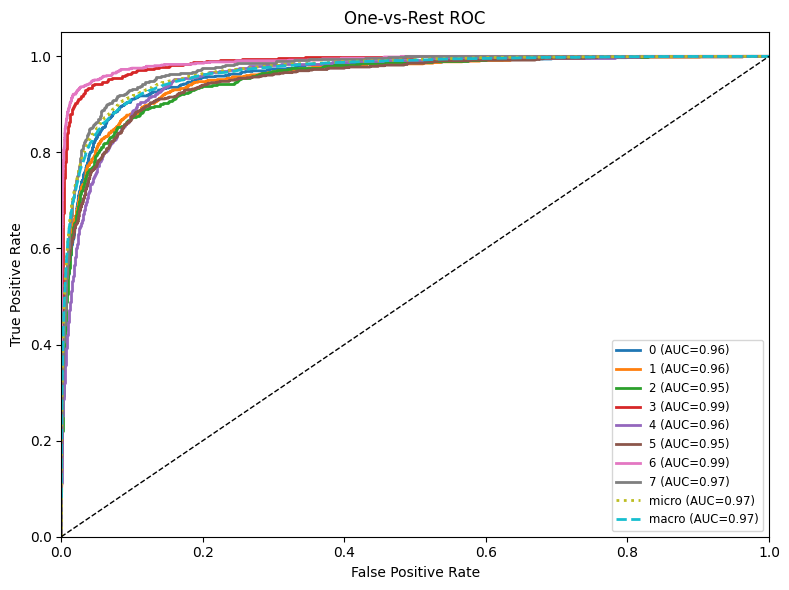

In [73]:
plot_ovr_roc(y_test, proba, classes=mlp_classifier_tfidf.classes_)

### Ejercicio

* Mejorar la clasificación con otros kernels, clasificadores, regularizaciones y/o haciendo mas eficiente la bolsa de palabras y el TD-IDF si es posible. Para esto explorar que otros clasificadores podrían usar, hacer más exhaustivo el analisis exploratorio y preprocesamiento, y revisar los links de scikit-learn para ver qué otros parámetros pueden usarse dentro de las clases CountVectorizer y TFIDFVectorizer. Tener en cuenta también el costo computacional debido a la maldición de la dimensión que sufren las matrices creadas por las clases ya nombradas.

![Colegio Bourbaki](./Images/Matematicas.png)

![Colegio Bourbaki](./Images/Contacto.png)